In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import pandas as pd
data = pd.read_csv('D:/model/App_Mobile_Emotion/training_model/ChangeDataSet/emotion_dataset.csv')
data.head(20)

,emotion,pixels,Usage
0,0,72 78 81 75 59 54 63 61 55 55 62 46 93 114 121...,Training
1,0,152 149 147 157 146 133 114 138 170 175 184 15...,Training
2,0,29 25 21 23 26 24 49 67 85 101 121 125 130 140...,Training
3,0,32 23 20 56 43 34 38 46 92 99 34 21 27 27 31 4...,Training
4,0,222 218 202 189 199 208 193 134 103 89 37 41 5...,Training
5,0,238 239 237 234 232 228 231 203 170 152 166 18...,Training
6,0,35 26 25 14 12 14 17 20 22 22 24 24 46 35 29 2...,Training
7,0,120 119 120 121 121 122 122 123 122 120 124 12...,Training
8,0,255 255 254 255 250 223 179 125 119 106 96 97 ...,Training
9,0,73 77 79 105 130 128 92 81 76 55 58 44 71 76 7...,Training


<Figure size 1400x800 with 0 Axes>

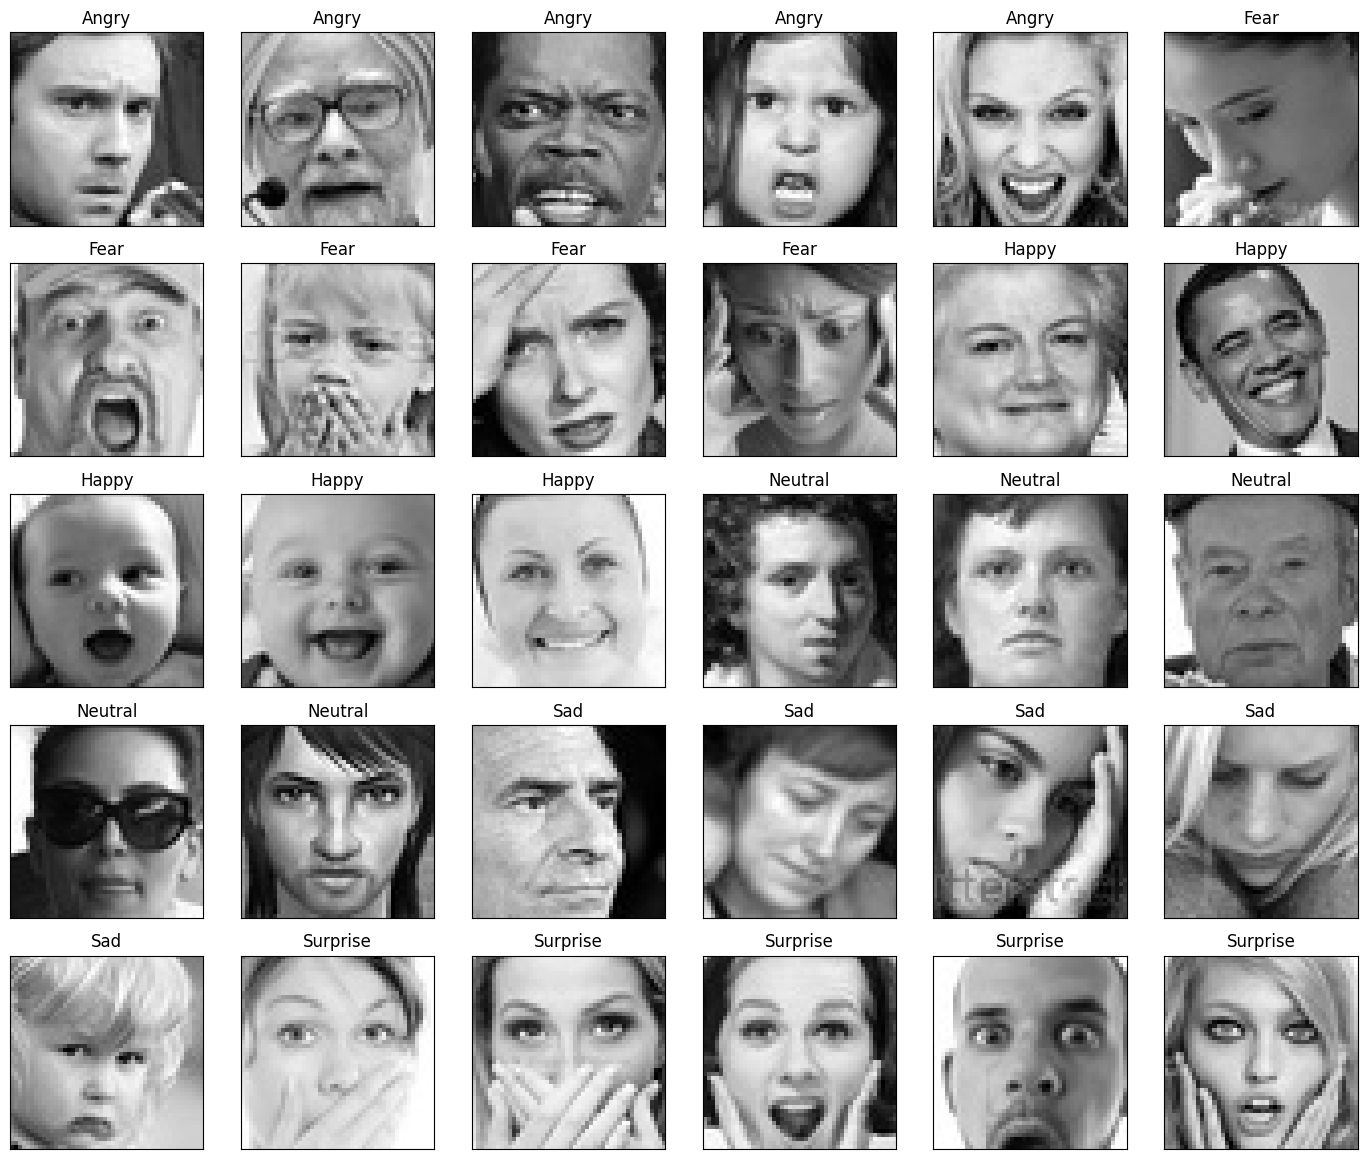

<Figure size 1400x800 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
label_to_text = {
    0: 'Angry',
    1: 'Fear',
    2: 'Happy',
    3: 'Neutral',
    4: 'Sad',
    5: 'Surprise'
}

fig = plt.figure(1, (14, 14))
k = 0

for label in sorted(data['emotion'].unique()):
    subset = data[data['emotion'] == label].head(5)  # Lấy 5 ảnh đầu của mỗi nhãn
    for i in range(len(subset)):
        pixel_string = subset.iloc[i]['pixels']
        px = np.array(pixel_string.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(6, 6, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

plt.figure(figsize=(14, 8))

In [4]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
# --- Cấu hình ---
IMG_SIZE = 96    # Resize ảnh nhỏ hơn cho ResNet18 custom
NUM_CLASSES = 6

# --- 1. Đọc dữ liệu ---
data = pd.read_csv('D:/model/App_Mobile_Emotion/training_model/ChangeDataSet/emotion_dataset.csv')
x_data = data['pixels']
y_data = data['emotion']

# --- 2. Oversampling để cân bằng nhãn ---
oversampler = RandomOverSampler(sampling_strategy='auto')
x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1, 1), y_data)

# --- 3. Chuyển chuỗi pixel thành mảng numpy ---
x_data = pd.Series(x_data.flatten())
x_data = np.array(list(map(str.split, x_data)), dtype=np.float32)
x_data /= 255.0   # Chuẩn hóa pixel về [0,1]
x_data = x_data.reshape(-1, 48, 48)  # Ảnh grayscale ban đầu

# --- 4. Resize lên 96x96 và chuyển grayscale sang 3 kênh RGB ---
x_data_resized = []
for img in tqdm(x_data, desc="Resizing and converting to RGB"):
    resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize ảnh về 96x96
    rgb_img = np.stack((resized_img,) * 3, axis=-1)     # Grayscale -> RGB 3 kênh
    x_data_resized.append(rgb_img)

x_data_resized = np.array(x_data_resized, dtype=np.float32)

# --- 5. One-hot encoding nhãn ---
y_data = np.array(y_data).reshape(-1, 1)
y_data = to_categorical(y_data, num_classes=NUM_CLASSES)

# --- 6. Chia tập huấn luyện và kiểm tra ---
x_train, x_test, y_train, y_test = train_test_split(x_data_resized, y_data, test_size=0.1, random_state=45)

data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# --- 7. Kiểm tra kích thước ---
print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)


Resizing and converting to RGB: 100%|██████████| 42984/42984 [00:04<00:00, 8627.70it/s]


Train shape: (38685, 96, 96, 3) (38685, 6)
Test shape: (4299, 96, 96, 3) (4299, 6)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2  # THÊM DÒNG NÀY

def conv_block(x, filters, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False,
               kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False,
               kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False,
                          kernel_regularizer=l2(0.001))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet18(input_shape=(96, 96, 3), num_classes=6):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False,
               kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = conv_block(x, 64, strides=1)
    x = conv_block(x, 64, strides=1)

    x = conv_block(x, 128, strides=2)
    x = conv_block(x, 128, strides=1)

    x = conv_block(x, 256, strides=2)
    x = conv_block(x, 256, strides=1)

    x = conv_block(x, 512, strides=2)
    x = conv_block(x, 512, strides=1)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax',
                    kernel_regularizer=l2(0.001))(x)

    model = Model(inputs, outputs)
    return model

# Khởi tạo model
model = build_resnet18()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 24, 24,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_4[0][0]  

 Total params: 11,189,190 (42.68 MB)

 Trainable params: 11,179,590 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/65
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.2954 - loss: 6.0509
Epoch 1: val_accuracy improved from -inf to 0.44336, saving model to best_resnet18_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 566s 459ms/step - accuracy: 0.2954 - loss: 6.0506 - val_accuracy: 0.4434 - val_loss: 5.1005 - learning_rate: 1.0000e-04
Epoch 2/65
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.5258 - loss: 4.7958
Epoch 2: val_accuracy improved from 0.44336 to 0.47360, saving model to best_resnet18_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 518s 429ms/step - accuracy: 0.5258 - loss: 4.7956 - val_accuracy: 0.4736 - val_loss: 4.4549 - learning_rate: 1.0000e-04
Epoch 3/65
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6691 - loss: 3.8681
Epoch 3: val_accuracy improved from 0.47360 to 0.59642, saving model to best_resnet18_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 506s 418ms/step - accuracy: 0.6691 - loss: 3.8679 - val_accuracy: 0.5964 - val_loss: 3.6908 - learning_rat

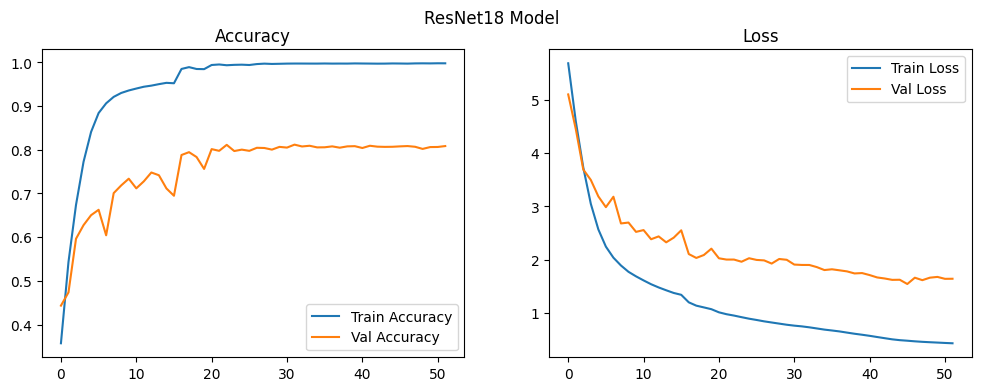

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Giả sử bạn đã chuẩn bị sẵn dữ liệu x_train, y_train, x_test, y_test
# với input shape = (96, 96, 3) hoặc thay đổi theo cấu hình của bạn

# 1. Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2. Callback để lưu model tốt nhất
checkpoint = ModelCheckpoint(
    'best_resnet18_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    verbose=1,
    restore_best_weights=True
)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 3. Huấn luyện model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=65,           # số epoch tùy chỉnh
    batch_size=32,
    callbacks=[checkpoint, early_stopping, learning_rate_reduction],
    shuffle=True,
    verbose=1
    
)
model.save('resnet18_model.keras')  # Lưu model sau khi huấn luyện
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.suptitle("ResNet18 Model")  # Tiêu đề cho toàn bộ figure
plt.show()


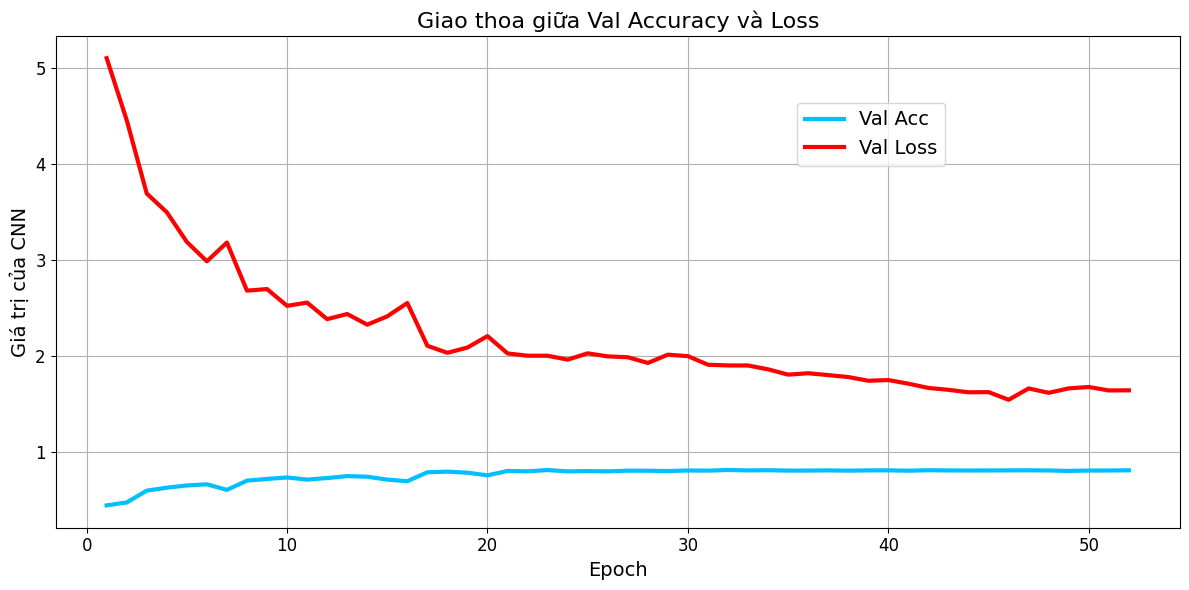

In [11]:
import matplotlib.pyplot as plt

# Giả sử history là kết quả từ model.fit()
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(val_acc) + 1)

plt.figure(figsize=(12, 6))

# Vẽ val_accuracy
plt.plot(epochs, val_acc, color='deepskyblue', linewidth=3, label='Val Acc')

# Vẽ val_loss
plt.plot(epochs, val_loss, color='red', linewidth=3, label='Val Loss')

# Cài đặt trục
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Giá trị của CNN', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Chú thích nằm bên trái
plt.legend(loc='center right', bbox_to_anchor=(0.8, 0.8), fontsize=14)

# Tiêu đề
plt.title('Giao thoa giữa Val Accuracy và Loss', fontsize=16)

# Hiển thị
plt.grid(True)
plt.tight_layout()
plt.show()


135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step
📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.84      0.82      0.83       728
        fear       0.81      0.81      0.81       735
       happy       0.81      0.76      0.78       728
     neutral       0.74      0.79      0.76       729
         sad       0.73      0.71      0.72       699
    surprise       0.91      0.97      0.94       680

    accuracy                           0.81      4299
   macro avg       0.81      0.81      0.81      4299
weighted avg       0.81      0.81      0.81      4299



C:\Users\DELL\AppData\Local\Temp\ipykernel_5736\1681813507.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


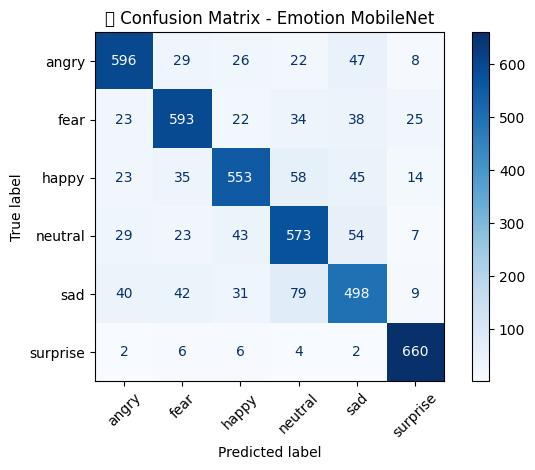

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán xác suất
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# 📋 In báo cáo phân loại với nhãn
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📊 Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("📊 Confusion Matrix - Emotion MobileNet")
plt.tight_layout()
plt.show()